### Inferential Statistics - Springboard CapstoneOne: Market Basket Analysis

The goal of this notebook is to apply inferential statistics to the Market Basket project data.  We do analsysis from two perspectives:


**One:** compare statistics from test and train datasets and verify that there are no statistically significant differences between the two populations.  We check two statistics:

    `Reorder Proportion Overall`

    `User Propensity to Reorder -- Mean`

**Two:** compare a model candidate statistic to show that its subgroups have statistically significant differences on the outcome of interest, ordering behaviour.    

    `Hour of Day (HOD) Reorder Proportion`
 
 
 

# Import and Preview data from each of the input files:
 
 'aisles.csv',
 'departments.csv',
 'orders.csv',
 'order_products__prior.csv',
 'order_products__train.csv',
 'products.csv',


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# import sklearn modules

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [3]:
aisles = pd.read_csv('data\\aisles.csv')
departments = pd.read_csv('data\\departments.csv')
orders = pd.read_csv('data\\orders.csv')
order_products__prior = pd.read_csv('data\\order_products__prior.csv')
order_products__train = pd.read_csv('data\\order_products__train.csv')
products = pd.read_csv('data\\products.csv')

In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
orders.eval_set.unique()


array(['prior', 'train', 'test'], dtype=object)

In [8]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
order_products__train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             1384617 non-null int64
product_id           1384617 non-null int64
add_to_cart_order    1384617 non-null int64
reordered            1384617 non-null int64
dtypes: int64(4)
memory usage: 42.3 MB


In [11]:
order_products__prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


In [12]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13




# Explore orders.eval_set

The orders dataframe contains tags indicating if that order should be used for training.  The 'test' subset is for competition submission and for which we do not have outcomes, and hence cannot use for model-development.

We will extract the train subset, and split it into local train and test portions.

In [13]:
orders.eval_set.unique()

array(['prior', 'train', 'test'], dtype=object)

# Split the Kaggle train data into local train, test data

Use full data set


In [14]:
xop = order_products__prior
xopt = order_products__train
xorders = orders

In [15]:
# categorize orders
# orders.eval_set.unique()
# array(['prior', 'train', 'test'], dtype=object)

testsize = 0.3

orderstrain = orders[orders.eval_set == 'train']

# partition orderstrain into local train, test data:   otrain, otest
otrain, otest = train_test_split(orderstrain, test_size=testsize, random_state=43)
otrain.shape, otest.shape

((91846, 7), (39363, 7))

In [16]:
# get orderids and use to split the orderproducts information
orderidtraintemp = pd.DataFrame(otrain.order_id.unique(),columns=['order_id']   )
orderidtesttemp = pd.DataFrame(otest.order_id.unique(),columns=['order_id']   )

# split the orders product into train test subsets
optrain = pd.merge(orderidtraintemp, order_products__train, on=['order_id'])
optest = pd.merge(orderidtesttemp, order_products__train, on=['order_id'])

In [17]:
# do a quick check on the reordered mean stat between groups
optest.reordered.mean(), optrain.reordered.mean()

(0.6005062741836329, 0.5977767054160454)

In [18]:
#verify no duplicate users in orders
orderstrain.user_id.value_counts().sort_values(ascending=False)

6147     1
82984    1
39059    1
55323    1
10245    1
        ..
49128    1
45034    1
32752    1
30705    1
8188     1
Name: user_id, Length: 131209, dtype: int64

# INFERENTIAL STATS
We first define functions and then use them for the analysis

ECDF (Exploratory Cumulative Distribution Function) generator

In [19]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange (1, len(x) + 1) / n

    return x, y


Functions to draw permutation samples:

* from a single table, 
* from a pair of related tables

In [20]:
   
def permutation_sample(d1, d2):
    ''' return a permutation sample from d1 and d2'''
    # combine data
    d12 = np.concatenate((d1,d2))
    # permutate data
    d12perm = np.random.permutation(d12)
    # split data
    samp1 = d12perm[:len(d1)]
    samp2 = d12perm[len(d1):]
    return samp1, samp2

# return a permuted order_products sample from orders o1 and o2 and order prodcuts op
def permutation_sample_op(d1, d2, op, joincols, returncol):
    ''' return a permuted sample consisting of values from op.returncol based on permutating
        datasets d1, d2  and merging the results with op on columns joincols'''
    # combine data
    d12 = np.concatenate((d1,d2))
    # permutate data
    d12perm = np.random.permutation(d12)
    # split data
    temp1 = d12perm[:len(d1)]
    temp2 = d12perm[len(d1):]
    
    op1 = pd.merge(pd.DataFrame({joincols:temp1}), op, on=joincols)
    op2 = pd.merge(pd.DataFrame({joincols:temp2}), op, on=joincols)
    
    return op1[returncol], op2[returncol]

Functions to generate bootstrap replicates:
* from a single table
* from a pair of related tables

In [21]:
def permutation_reps(d1, d2, func, size=1):
    '''Return bootstrap permucation replicates for datasets d1, d2 using function func'''
    perm_reps = np.empty(size)
    for i in range(size):
        perm1, perm2 = permutation_sample(d1, d2)
        perm_reps[i] = func(perm1, perm2)
    return perm_reps
    
def permutation_reps_op(d1, d2, op, joincols, returncol, func, size=1):
    '''Return bootstrap replicates for dataframes d1, d2 (merged with dataframe op on joincols)and returning 
    the result of function func performed on column returncol from dataframe op '''
    perm_reps = np.empty(size)
    for i in range(size):
        perm1, perm2 = permutation_sample_op(d1, d2, op, joincols, returncol)
        perm_reps[i] = func(perm1, perm2)
    return perm_reps
    

In [22]:
def mean_diff(d1, d2):
    '''Return the difference of the means of d1 and d2'''
    return (np.mean(d1) - np.mean(d2))


# Compare Overall Reorder proportion for train, test

We use bootstrap samples on the local test/train data to compare  the difference of reoorder proportions 


    H0: reorder prop train = reorder prop test ==> test - learn = 0

    H1: reorder prop train != reorder prop test ==> |test - learn| > 0


In [23]:
diff_actual = mean_diff(optest.reordered, optrain.reordered)

diff_actual, np.mean(optest.reordered), np.mean(optrain.reordered)

(0.0027295687675874536, 0.6005062741836329, 0.5977767054160454)

The bootstrap sampling needs to handle data being in two different tables.  

The data is split by order_id, while the details are in a 1:m relationship with the order_products table.


In [24]:
xd1 = otrain.order_id
xd2 = otest.order_id
 
xjoincols = 'order_id'
xreturncol = 'reordered'
 
diffreps = permutation_reps_op(xd1, xd2, xopt, xjoincols, xreturncol, mean_diff ,size=1000)

In [25]:
diffreps.shape, diffreps.max(), diffreps.min(), diff_actual

((1000,), 0.005474164766643197, -0.005642289640160891, 0.0027295687675874536)

Text(0, 0.5, 'Count')

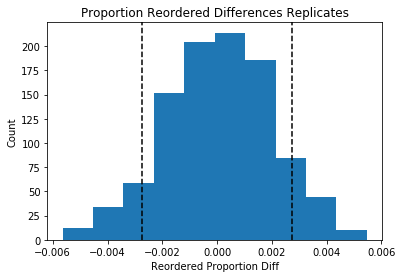

In [26]:
# Plot the replicate distribution, along with absolute value of the actual difference
plt.hist(diffreps)
plt.axvline(x=diff_actual, color='k', linestyle='--')
plt.axvline(x=-diff_actual, color='k', linestyle='--')

plt.title('Proportion Reordered Differences Replicates')
plt.xlabel('Reordered Proportion Diff')
plt.ylabel('Count')


In [27]:
# p-value
 
p_RePropDiff = np.sum(abs(diffreps) > abs(diff_actual)  )/len(diffreps)
p_RePropDiff


0.159

The p-value above of 0.146 (for 0.3 test split) indicates that the reordered proportions are not statistically different between the test and train dataset. 

In [28]:
diff_actual

0.0027295687675874536

# User Propensity to Reorder

We compare the means of the user reorder proportions. The reorder proportion is calculated for each user, and then the user associated with the test/train orders is used in the calculation.  NOTE: we verified that there are not multiple orders for a user in the test/train data. 

In [29]:
# time of day (tod) -- reuse this from EDA....
tod = pd.merge(xorders[['user_id','order_id','order_dow','order_hour_of_day']],
        xop[['order_id','reordered']])

 

todKaggleTrain = pd.merge(orderstrain[['user_id','order_id','order_dow','order_hour_of_day']],
        xopt[['order_id','reordered']])
todKaggleTrain.head()

,user_id,order_id,order_dow,order_hour_of_day,reordered
0,1,1187899,4,8,1
1,1,1187899,4,8,1
2,1,1187899,4,8,1
3,1,1187899,4,8,1
4,1,1187899,4,8,1


Text(0.5, 1.0, 'Reorder Proportion by User Train+Test')

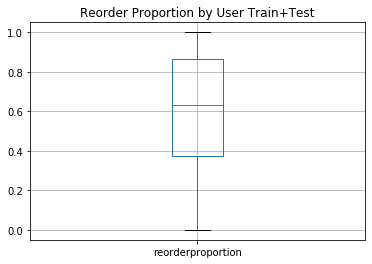

In [30]:
# plot the reorder proportion for Kaggle Train population
reorderproportionbyuser = todKaggleTrain.groupby(['user_id']).agg(reorderproportion=('reordered','mean')).reset_index()

reorderproportionbyuser.describe()
reorderproportionbyuser[['reorderproportion']].boxplot()
plt.title('Reorder Proportion by User Train+Test')


In [31]:
# decode orders to user_ids, and pass reorder proportion to sampler...

upropensitytest = pd.merge(otest[['order_id','user_id']], reorderproportionbyuser, 
                           on='user_id'  )['reorderproportion']
upropensitytrain = pd.merge(otrain[['order_id','user_id']], reorderproportionbyuser, 
                            on='user_id'  )['reorderproportion']
 
upropensityDiffActual = mean_diff(upropensitytrain, upropensitytest)
upropensityDiffActual, np.mean(upropensitytrain), np.mean(upropensitytest)
                                  

(-0.0028864803792755245, 0.6016062438460876, 0.6044927242253632)

In [32]:
upropensityDiffReps = permutation_reps(upropensitytrain, upropensitytest, mean_diff, size=1000)
 

Text(0, 0.5, 'Replicate Frequency')

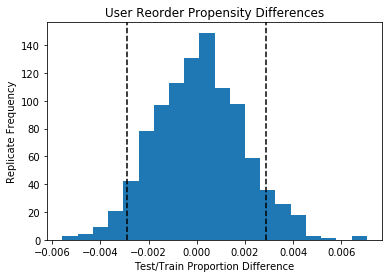

In [33]:
plt.hist(upropensityDiffReps, bins=20 )
plt.axvline(x=upropensityDiffActual, color='k', linestyle='--')
plt.axvline(x=-upropensityDiffActual, color='k', linestyle='--')
plt.title('User Reorder Propensity Differences')
plt.xlabel('Test/Train Proportion Difference')
plt.ylabel('Replicate Frequency')

In [34]:
# p-value
p_upropensityDiff = np.mean(abs(upropensityDiffReps) >= abs(upropensityDiffActual))
p_upropensityDiff

0.116

From the p-value above, differences at least as extreme as the current observation occurred in 83% of the samples (for .4 test split)...
 .... 31% for .3 test split 
 ...therefore we are confident that there is no statistical difference in the test and train 
 populations for the user propensity to reorder for a 0.3 test split

Text(0, 0.5, 'CDF')

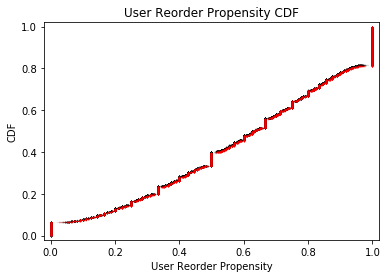

In [35]:
# plot the ECDFs to verify the user reorder propensity distribution is similar for the local test/train populations
xtrain, ytrain = ecdf(upropensitytrain)
xtest, ytest = ecdf(upropensitytest)


# Overlay the plots
plt.plot(xtrain, ytrain,marker='.', linestyle='none', c='k', markersize=1, alpha=0.1 )
plt.plot(xtest, ytest, marker='.', linestyle='none', c='r', markersize=1, alpha=0.1)
plt.margins(0.02)
plt.title('User Reorder Propensity CDF')
plt.xlabel('User Reorder Propensity')
plt.ylabel('CDF')

The  ECDF plot above indicates that it is likely that the two populations came from the same distribution

## Reorder Proportion  by Hour of Day - Effect on outcome

The proportion of basket items reordered varies by hour of day: with orders early in the morning (between 5 and 9 o'clock)  more likely to have a higher proportion of reordered items. We do not do a comparison between all combinations of hours of the day, but show that it can be significant between various hours.  In particular we use hours 7, 14; we evaluate hour combination 6,7 for comparision, since they are closer in differences. 

We show, that for the entire dataset, and 1k replication samples, and 0.3 test split:

    The reorder proportion for hours 7,14 is significantly different, while hours 6,7 is borderline significant (and hence susceptable to test split fraction used).  But nonetheless, differences exist between various hours of day, and hence may be candiates for predicting model outcome.

In [36]:
# Hour of Day (HOD) Reorder proportion significance -- use all 'prior' data...used in training the model
# check: between 6,7 and 7,14

hodproportion = tod.groupby(['order_id','order_hour_of_day']).agg(reorderproportion=('reordered','mean')).reset_index()

hodprop6 = hodproportion[hodproportion.order_hour_of_day==6]['reorderproportion'] 
hodprop7 = hodproportion[hodproportion.order_hour_of_day==7]['reorderproportion']
hodprop14 = hodproportion[hodproportion.order_hour_of_day==14]['reorderproportion']

### We first plot the propportion reordered distributions for hour of day

Since it appears that the distributions may not all be the same, we do further validation by plotting the ECDFs for each population.



Text(0.5, 1.0, 'Proportion reordered by Hour of Day')

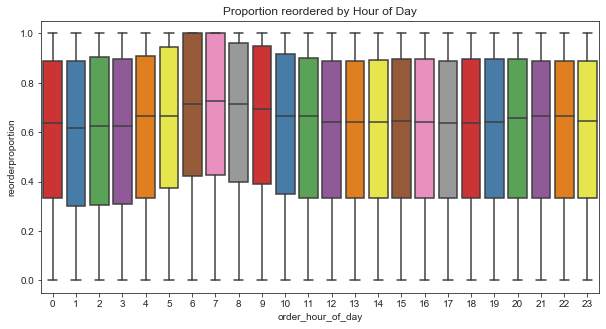

In [37]:
# Hour of Day reorder proportion (hod)
#hodproportion = tod.groupby(['order_id','order_hour_of_day']).agg(reorderproportion=('reordered','mean')).reset_index()

sns.set_style('ticks')
fig, ax = plt.subplots()
# set size
fig.set_size_inches(10, 5)

sns.boxplot(x="order_hour_of_day", y="reorderproportion", 
            data=hodproportion, 
            palette="Set1")
plt.title('Proportion reordered by Hour of Day')


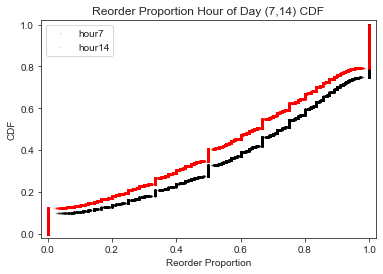

In [38]:
# plot the ECDF for  HOD reorder
xtrain, ytrain = ecdf(hodprop7)
xtest, ytest = ecdf(hodprop14)


# Overlay the plots
plt.plot(xtrain, ytrain,marker='.', linestyle='none', c='k', markersize=2, alpha=0.1, label='hour7' )
plt.plot(xtest, ytest, marker='.', linestyle='none', c='r', markersize=2, alpha=0.1, label='hour14')
plt.margins(0.02)
plt.title('Reorder Proportion Hour of Day (7,14) CDF')
plt.xlabel('Reorder Proportion')
plt.ylabel('CDF')
plt.legend(loc="upper left")

The ECDFs for hours 7, 14 illustrate the difference in distributions and we shift the means when doing the difference of the means analysis (even though hours 6,7...shown below..appear more similar) 

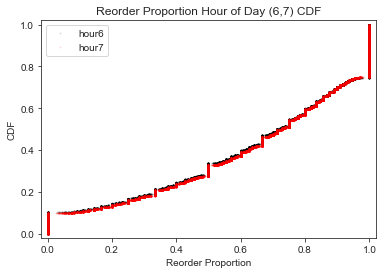

In [39]:
# plot the ECDF for  HOD reorder
xtrain, ytrain = ecdf(hodprop6)
xtest, ytest = ecdf(hodprop7)


# Overlay the plots
plt.plot(xtrain, ytrain,marker='.', linestyle='none', c='k', markersize=2, alpha=0.1, label='hour6' )
plt.plot(xtest, ytest, marker='.', linestyle='none', c='r', markersize=2, alpha=0.1, label='hour7')
plt.margins(0.02)
plt.title('Reorder Proportion Hour of Day (6,7) CDF')
plt.xlabel('Reorder Proportion')
plt.ylabel('CDF')
plt.legend(loc="upper left")

The ECDFS for hours 6,7 appear more similar than 7,14 above

# shifted difference of mean for HOD ReOrder Proportion

In [40]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [41]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


In [42]:
# Compute mean of proportions: mean_prop


# Compute actual means
hod714propDiffActual = mean_diff(hodprop7, hodprop14)
hod67propDiffActual = mean_diff(hodprop6, hodprop7)


# Days 7,14
hodprop714 = np.concatenate((hodprop7.values, hodprop14.values))
mean_prop714 = np.mean(hodprop714)
mean_prop714, np.mean(hodprop7), np.mean(hodprop14)

# Days 6,7
hodprop67 = np.concatenate((hodprop6.values, hodprop7.values))
mean_prop67 = np.mean(hodprop67)
mean_prop67, np.mean(hodprop6), np.mean(hodprop7)


(0.6484311027594556, 0.6444719529665801, 0.6497465551324912)

In [43]:
# Generate shifted arrays
hodprop7_shifted = hodprop7 - np.mean(hodprop7) + mean_prop714
hodprop14_shifted = hodprop14 - np.mean(hodprop14) + mean_prop714 


hodprop76_shifted = hodprop7 - np.mean(hodprop7) + mean_prop67
hodprop6_shifted = hodprop6 - np.mean(hodprop6) + mean_prop67 

In [44]:
# Compute 1,000 bootstrap replicates from shifted arrays
hodprop7_reps = draw_bs_reps(hodprop7_shifted, np.mean, 1000)
hodprop14_reps = draw_bs_reps(hodprop14_shifted, np.mean, 1000)

hodprop76_reps = draw_bs_reps(hodprop76_shifted, np.mean, 1000)
hodprop6_reps = draw_bs_reps(hodprop6_shifted, np.mean, 1000)

In [45]:
# Get replicates of difference of means: bs_replicates
hodprop714reps = hodprop14_reps - hodprop7_reps
hodprop67reps = hodprop76_reps - hodprop6_reps

Text(0, 0.5, 'Replicate Frequency')

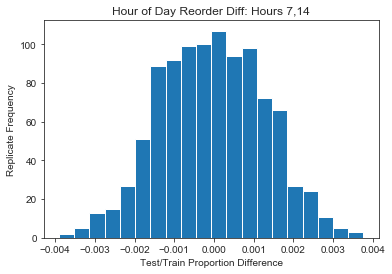

In [46]:
# plot 7, 14
plt.hist(hodprop714reps, bins=20)
plt.title('Hour of Day Reorder Diff: Hours 7,14')
plt.xlabel('Test/Train Proportion Difference')
plt.ylabel('Replicate Frequency')

In [47]:
# Compute and print 7,14 p-value: p
p = sum(abs(hodprop714reps) > abs(hod714propDiffActual) ) / len(hodprop714reps)
print('p-value =', p   ,'; actual Difference = ', hod714propDiffActual) 

p-value = 0.0 ; actual Difference =  0.060422909061740415


From the p-value above we see that the difference of the mean reorder proportions is statistically different between hours of 7, 14 (p-value < .001)

NOTE: we do not include the actual difference on the plot above since it is so far from the replicate values

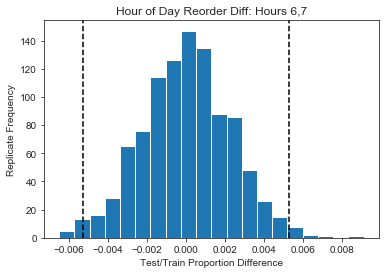

In [48]:
# plot hours 6, 7

plt.hist(hodprop67reps, bins=20)
plt.title('Hour of Day Reorder Diff: Hours 6,7')
plt.xlabel('Test/Train Proportion Difference')
plt.ylabel('Replicate Frequency')

plt.axvline(x=hod67propDiffActual, color='k', linestyle='--')
plt.axvline(x=-hod67propDiffActual, color='k', linestyle='--')

In [49]:
# Compute and print 6,7 p-value: p
phod67 = sum(abs(hodprop67reps) > abs(hod67propDiffActual) ) / len(hodprop67reps)
print('p-value =', phod67   ,'; actual Difference = ', hod67propDiffActual)

p-value = 0.024 ; actual Difference =  -0.005274602165911135


From the p-value above we see that the difference of the mean reorder proportions is statistically different between hours of 6, 7 (p = 0.025). 
